In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 制作数据集

# 设定下载参数
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0.1307, 0.3081)
])

# 下载训练集与测试集
train_Data = datasets.MNIST(
    root = 'D:/Jupyter/dataset/mnist/',
    train = True,
    download = True,
    transform = transform
)
test_Data = datasets.MNIST(
    root = 'D:/Jupyter/dataset/mnist/',
    train = False,
    download = True,
    transform = transform
)

In [4]:
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=128)
test_loader  = DataLoader(test_Data, shuffle=False, batch_size=128)

In [5]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        y = self.net(x)
        return nn.functional.relu(x+y)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(16),
            nn.Conv2d(16, 32, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32), 
            nn.Flatten(),
            nn.Linear(512, 10)
        )
 
    def forward(self, x):
        y =  self.net(x)
        return y

In [7]:
# 查看网络结构
X = torch.rand(size= (1, 1, 28, 28))
for layer in CNN().net:
    X = layer(X)
    print( layer.__class__.__name__, 'output shape: \t', X.shape )

Conv2d output shape: 	 torch.Size([1, 16, 24, 24])
ReLU output shape: 	 torch.Size([1, 16, 24, 24])
MaxPool2d output shape: 	 torch.Size([1, 16, 12, 12])
ResidualBlock output shape: 	 torch.Size([1, 16, 12, 12])
Conv2d output shape: 	 torch.Size([1, 32, 8, 8])
ReLU output shape: 	 torch.Size([1, 32, 8, 8])
MaxPool2d output shape: 	 torch.Size([1, 32, 4, 4])
ResidualBlock output shape: 	 torch.Size([1, 32, 4, 4])
Flatten output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 10])


In [8]:
# 创建子类的实例，并搬到GPU上
model = CNN().to('cuda:0')

In [9]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss()

In [10]:
# 优化算法的选择
learning_rate = 0.1    # 设置学习率
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr = learning_rate, 
)

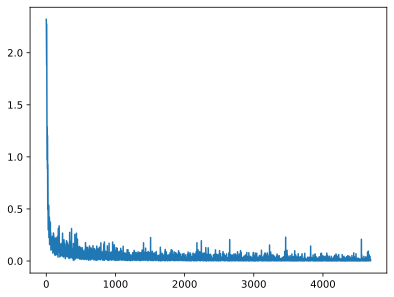

In [11]:
# 训练网络
epochs = 10
losses = []        # 记录损失函数变化的列表

for epoch in range(epochs):
    for (x, y) in train_loader:                  # 获取小批次的x与y
        x, y = x.to('cuda:0'), y.to('cuda:0')    # 把小批次搬到GPU上
        Pred = model(x)                          # 一次前向传播（小批量）
        loss = loss_fn(Pred, y)                  # 计算损失函数
        losses.append(loss.item())               # 记录损失函数的变化
        optimizer.zero_grad()                    # 清理上一轮滞留的梯度
        loss.backward()                          # 一次反向传播
        optimizer.step()                         # 优化内部参数

Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [12]:
# 测试网络
correct = 0
total = 0

with torch.no_grad():                                   # 该局部关闭梯度计算功能
    for (x, y) in test_loader:                          # 获取小批次的x与y
        x, y = x.to('cuda:0'), y.to('cuda:0')           # 把小批次搬到GPU上
        Pred = model(x)                                 # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0) 
        
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 99.06999969482422 %
